## Imports

In [16]:
#!pip install --upgrade scikit-learn 
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.1 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.9.1
    Uninstalling imbalanced-learn-0.9.1:
      Successfully uninstalled imbalanced-learn-0.9.1


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

In [3]:
data = pd.read_csv("../raw_data/final_file_with_all_features.csv",low_memory=False)

## Variables

In [4]:
X = data.drop("Age abandoned school", axis=1)
y = data["Age abandoned school"]

In [5]:
X.columns

Index(['hhid', 'Gender', 'mother_alive', 'father_alive', 'parents_age',
       'marital_status', 'darija', 'class_arabic', 'french', 'amazygh',
       'read_one_lang', 'write_one_lang', 'no_read_write', 'parents_level_ed',
       'num_per_house', 'type_housing', 'automobiles', 'mobile_phones',
       'satellite', 'no_water', 'individual_water_net', 'electrical_net_co',
       'school_id', 'child_enrollment', 'class_when_dropout', 'region',
       'province', 'schoolunitid', 'type_unit', 'groupid', 'num_menage',
       'done_test', 'work_activity_classified'],
      dtype='object')

In [6]:
X = X.drop(columns={"darija","class_arabic","french","amazygh"})

In [7]:
X.columns

Index(['hhid', 'Gender', 'mother_alive', 'father_alive', 'parents_age',
       'marital_status', 'read_one_lang', 'write_one_lang', 'no_read_write',
       'parents_level_ed', 'num_per_house', 'type_housing', 'automobiles',
       'mobile_phones', 'satellite', 'no_water', 'individual_water_net',
       'electrical_net_co', 'school_id', 'child_enrollment',
       'class_when_dropout', 'region', 'province', 'schoolunitid', 'type_unit',
       'groupid', 'num_menage', 'done_test', 'work_activity_classified'],
      dtype='object')

In [8]:
X = X.drop(columns={"satellite"})

In [9]:
X = X.drop(columns={"read_one_lang","no_read_write","read_one_lang"})

In [33]:
X = X.drop(columns=["child_enrollment","class_when_dropout","schoolunitid","type_unit","groupid","num_menage","done_test"])

In [63]:
X.shape

(4052, 18)

## Pipeline

### Numerical features only

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train.set_index('hhid', inplace=True)
X_test.set_index('hhid', inplace=True)

oversample = RandomOverSampler()
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train_num = X_train.select_dtypes(include=["float64","int64"])
X_test_num = X_test.select_dtypes(include=["float64","int64"])

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('standard_scaler', StandardScaler())]).set_output(transform="pandas")

pipeline.fit(X_train_num)
X_train_transformed = pipeline.transform(X_train_num)
X_test_transformed = pipeline.transform(X_test_num)

In [66]:
X_train_transformed.head()

,mother_alive,father_alive,parents_age,marital_status,write_one_lang,parents_level_ed,num_per_house,type_housing,automobiles,mobile_phones,no_water,individual_water_net,electrical_net_co,work_activity_classified
0,-0.871401,-1.297290,0.178261,-0.149739,0.557682,-0.53313,0.077118,-1.197654,0.210569,-0.740726,0.051832,0.437332,1.118708,-0.841112
1,-0.871401,-1.297290,-1.409859,-0.149739,0.557682,-0.53313,-0.965151,0.769848,0.210569,1.350026,0.051832,0.437332,1.118708,-0.841112
2,-0.871401,0.784286,0.707634,-0.149739,-1.827241,-0.53313,0.077118,1.753600,0.210569,-0.740726,0.051832,0.437332,-0.893888,2.032886
3,1.155133,0.784286,1.131133,-0.149739,0.557682,-0.53313,2.161655,-1.197654,0.210569,1.350026,0.051832,0.437332,1.118708,-0.841112
4,-0.871401,-1.297290,0.072386,-0.149739,0.557682,-0.53313,0.598252,0.769848,0.210569,-0.740726,0.051832,0.437332,-0.893888,-0.841112


## PCA & Features Permutation

### PCA

In [56]:
pca = PCA()
pca.fit(X_train_transformed)

# Metrics
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# Dimensionality reduction (Train)
X_proj_train = pca.transform(X_train_transformed)
X_proj_train = pd.DataFrame(X_proj_train, columns=[f'PC{i}' for i in range(1, X_train_transformed.shape[1]+1)])
X_proj_train

[0.16231054 0.11132179 0.0890009  0.08730227 0.07537298 0.07469807
 0.07066112 0.06109764 0.05760768 0.05562262 0.05008019 0.04767079
 0.04141216 0.01584125]
[105.00204912  86.958993    77.7537994   77.00823538  71.55372837
  71.2326527   69.28108228  64.42236132  62.55537206  61.46814969
  58.32535346  56.90502044  53.03814897  32.80341861]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.137803,-1.463310,0.761688,-1.012016,0.524823,-0.065753,-0.107300,-0.740553,0.735697,0.266584,-0.467504,1.000275,0.917748,0.002528
1,0.280072,-2.825127,-0.189754,-0.290552,-0.989307,0.070815,-0.089628,1.042039,0.012159,-0.512208,-0.081812,0.229615,-0.097804,-0.048586
2,0.606344,1.211978,-0.955487,0.538676,-0.148582,0.960465,-0.195215,-0.960849,-2.322573,-0.098318,-0.139165,-1.036587,0.422753,-1.642602
3,-2.349992,0.472053,2.271929,-0.638856,0.506673,-0.280388,-0.503282,0.309103,0.669080,-0.898829,0.762173,-0.128056,-0.320903,0.135676
4,0.581785,-0.700610,-0.814008,-1.736851,0.094635,-0.083870,0.070213,-0.870104,-0.214144,-0.351965,0.823344,0.237367,0.343746,0.022638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4847,-1.419138,-0.883718,1.394286,-0.082036,-0.027441,-0.281895,-0.179417,0.542965,0.713551,-0.186110,-0.028161,-0.815596,1.323210,0.022273
4848,1.038493,0.960712,0.124485,-0.759272,-0.467485,0.100282,-0.100822,-0.937866,-0.072665,-0.576077,0.369314,-1.175211,0.575408,-1.616264
4849,0.087402,-0.872668,-0.432579,0.121433,1.942603,-0.896330,0.409820,0.431004,0.145267,-0.075471,-1.731279,1.530250,0.921458,-0.081431
4850,-1.257423,1.021638,-0.112983,0.103694,0.270712,-0.602047,0.148436,-0.948337,0.294634,1.329179,0.181763,-0.034752,-0.454938,0.019185


In [58]:
# Dimensionality reduction (Test)
X_proj_test = pca.transform(X_test_transformed)
X_proj_test = pd.DataFrame(X_proj_test, columns=[f'PC{i}' for i in range(1, X_test_transformed.shape[1]+1)])
X_proj_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,0.042638,0.719737,-0.980576,0.004203,0.695481,-2.173188,0.809947,0.520849,1.796255,0.371116,-1.009507,0.056489,-1.229276,-0.065072
1,-0.642681,-2.105243,0.310483,0.291236,0.213327,0.267921,-0.197449,0.672715,-0.761872,0.024113,0.137056,0.552384,0.655878,-0.034442
2,-1.260489,-1.190376,0.919886,0.703121,-1.056347,-0.730692,-0.022529,0.987521,1.416953,0.592382,-0.445647,-0.205287,-1.039893,-0.022943
3,0.008417,-2.401709,0.229025,-0.727096,-0.456915,0.201874,-0.244769,0.835149,-0.196550,-0.977255,0.256491,0.185419,-0.059402,-0.000208
4,-0.669420,0.399996,-0.224552,-0.489565,-0.450816,-0.857810,0.330116,-0.776392,0.882151,1.214462,1.144115,1.920714,0.954276,-0.015749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,-0.230526,1.174935,-0.114013,0.189923,0.693705,-1.773164,0.438477,1.604982,0.537642,-1.171652,0.980506,0.470567,-0.197104,0.822321
807,0.878245,0.074311,-2.006509,-0.870261,0.391727,-1.262258,0.773471,0.501963,0.122967,-0.795165,-0.224036,1.156063,1.542694,-0.073611
808,-0.751892,-0.009373,-0.244560,-0.356591,-1.877031,0.027912,-0.072001,-0.192107,0.691621,-0.127225,-1.272381,0.369844,-0.689843,0.037424
809,-1.234785,0.663149,-0.564810,1.140476,2.653948,-1.257880,0.472335,1.185201,-1.041782,-0.005448,0.014384,-0.914991,0.946384,-0.057851


### Features permutation

In [59]:
# Fit model
model_nb = GaussianNB().fit(X_proj_train, y_train) 

# Performs Permutation
permutation_score = permutation_importance(model_nb, X_proj_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_proj_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

,feature,score decrease
0,PC1,0.039242
2,PC3,0.012984
1,PC2,0.008945
4,PC5,0.008677
9,PC10,0.00812
5,PC6,0.007172
8,PC9,0.006554
11,PC12,0.005874
6,PC7,0.003277
7,PC8,0.002782


## Modelling 

### Naive Bayse 

In [60]:
def perform(y_true, y_pred):
    print("Precision : ", precision_score(y_true, y_pred, average = 'micro'))
    print("Recall : ", recall_score(y_true, y_pred, average = 'micro'))
    print("Accuracy : ", accuracy_score(y_true, y_pred))
    print("F1 Score : ", f1_score(y_true, y_pred, average = 'micro'))
    cm = confusion_matrix(y_true, y_pred)
    print("\n", cm)
    print("\n")
    print("**"*27 + "\n" + " "* 16 + "Classification Report\n" + "**"*27)
    print(classification_report(y_true, y_pred))
    print("**"*27+"\n")
    
    cm = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm.plot()

Precision :  0.48581997533908755
Recall :  0.48581997533908755
Accuracy :  0.48581997533908755
F1 Score :  0.48581997533908755

 [[150  58]
 [359 244]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

         0.0       0.29      0.72      0.42       208
         1.0       0.81      0.40      0.54       603

    accuracy                           0.49       811
   macro avg       0.55      0.56      0.48       811
weighted avg       0.68      0.49      0.51       811

******************************************************



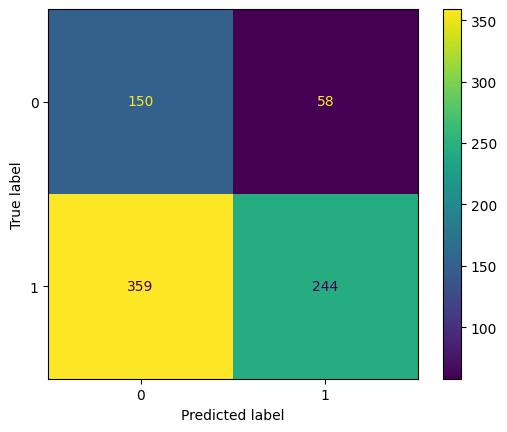

In [61]:
y_pred_nb = model_nb.predict(X_proj_test)
perform(y_test, y_pred_nb)

### SVC 

Precision :  0.5832305795314426
Recall :  0.5832305795314426
Accuracy :  0.5832305795314426
F1 Score :  0.5832305795314426

 [[125  83]
 [255 348]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

         0.0       0.33      0.60      0.43       208
         1.0       0.81      0.58      0.67       603

    accuracy                           0.58       811
   macro avg       0.57      0.59      0.55       811
weighted avg       0.68      0.58      0.61       811

******************************************************



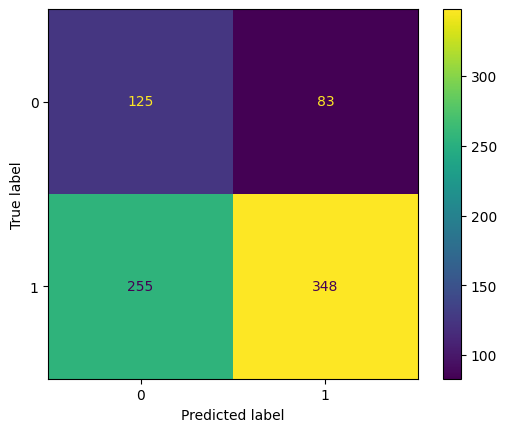

In [65]:
model_svc = SVC()
model_svc.fit(X_proj_train, y_train) 

# Performs Permutation
permutation_score = permutation_importance(model_svc, X_proj_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_proj_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

y_pred_svc = model_svc.predict(X_proj_test)
perform(y_test, y_pred_svc)

## Grid Search on PCA

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_components': [5, 10, 15],  
    'svd_solver': ['auto', 'full']  
}

# Create an instance of PCA
pca = PCA()

# Create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=pca, param_grid=param_grid, cv=5)

# Fit the GridSearchCV on your data
grid_search.fit(X_train_transformed)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Print the best score
print("Best Score:", grid_search.best_score_)